In [8]:
import pandas as pd

# Đọc dữ liệu từ file CSV
file_path = 'data.csv'
data = pd.read_csv(file_path, on_bad_lines='skip')

# Hiển thị các hàng đầu tiên của dữ liệu để xem cấu trúc
print(data.head())

# Kiểm tra các thông tin chung của tập dữ liệu
print(data.info())

# Kiểm tra các giá trị bị thiếu
print(data.isnull().sum())

# Thống kê mô tả của các cột số học
print(data.describe())


      password  strength
0     kzde5577         1
1     kino3434         1
2    visi7k1yr         1
3     megzy123         1
4  lamborghin1         1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669640 entries, 0 to 669639
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  669639 non-null  object
 1   strength  669640 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.2+ MB
None
password    1
strength    0
dtype: int64
            strength
count  669640.000000
mean        0.990196
std         0.507948
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000


In [9]:
# Xóa các hàng có giá trị bị thiếu trong cột 'password'
data_cleaned = data.dropna(subset=['password'])

# Chuyển đổi dữ liệu trong cột 'password' sang dạng chuỗi một cách an toàn
data_cleaned.loc[:, 'password'] = data_cleaned['password'].astype(str)

# Kiểm tra lại dữ liệu sau khi xử lý
print(data_cleaned.info())
print(data_cleaned.head())


<class 'pandas.core.frame.DataFrame'>
Index: 669639 entries, 0 to 669639
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   password  669639 non-null  object
 1   strength  669639 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB
None
      password  strength
0     kzde5577         1
1     kino3434         1
2    visi7k1yr         1
3     megzy123         1
4  lamborghin1         1


In [3]:
# Hàm trích xuất đặc trưng nâng cao từ mật khẩu
def extract_advanced_features(password):
    features = {
        'length': len(password),
        'uppercase_count': sum(1 for c in password if c.isupper()),
        'lowercase_count': sum(1 for c in password if c.islower()),
        'digit_count': sum(1 for c in password if c.isdigit()),
        'special_char_count': sum(1 for c in password if not c.isalnum()),
        'repeat_char_count': len(password) - len(set(password)),  # Số ký tự lặp lại
        'consecutive_digits_count': sum(1 for i in range(len(password)-1) if password[i].isdigit() and password[i+1].isdigit()),
        'consecutive_letters_count': sum(1 for i in range(len(password)-1) if password[i].isalpha() and password[i+1].isalpha()),
        'char_variety': len(set(c.isupper() for c in password)) + len(set(c.islower() for c in password)) +
                        len(set(c.isdigit() for c in password)) + len(set(not c.isalnum() for c in password)),
    }
    return features

# Áp dụng hàm trích xuất đặc trưng nâng cao cho mỗi mật khẩu
advanced_features_df = data_cleaned['password'].apply(extract_advanced_features).apply(pd.Series)

# Thêm cột 'strength' vào DataFrame các đặc trưng nâng cao
advanced_features_df['strength'] = data_cleaned['strength']

# Hiển thị vài hàng đầu tiên của DataFrame mới để kiểm tra kết quả
print(advanced_features_df.head())


   length  uppercase_count  lowercase_count  digit_count  special_char_count  \
0       8                0                4            4                   0   
1       8                0                4            4                   0   
2       9                0                7            2                   0   
3       8                0                5            3                   0   
4      11                0               10            1                   0   

   repeat_char_count  consecutive_digits_count  consecutive_letters_count  \
0                  2                         3                          3   
1                  2                         3                          3   
2                  1                         0                          4   
3                  0                         2                          4   
4                  0                         0                          9   

   char_variety  strength  
0             6         1  


In [10]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Đảm bảo cột 'password' không còn trong DataFrame chứa đặc trưng
# Nếu 'password' vẫn còn, hãy loại bỏ nó
advanced_features_df = advanced_features_df.drop(columns=['password'], errors='ignore')

# Tách đặc trưng và nhãn
X = advanced_features_df.drop(columns=['strength'])  # Chỉ chứa các đặc trưng
y = advanced_features_df['strength']  # Nhãn mục tiêu

# Chuẩn hóa dữ liệu bằng MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Lưu scaler để sử dụng trong tương lai
joblib.dump(scaler, 'scaler.pkl')

# Lưu lại tập dữ liệu đã chuẩn hóa (bao gồm cả nhãn 'strength')
processed_data = pd.DataFrame(X_scaled, columns=X.columns)
processed_data['strength'] = y.values
processed_data.to_csv('processed_password_data.csv', index=False)

print("Dữ liệu đã được chuẩn hóa và lưu thành công.")


Dữ liệu đã được chuẩn hóa và lưu thành công.


In [11]:
import pandas as pd
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Đọc dữ liệu đã được tiền xử lý
data = pd.read_csv('processed_password_data.csv')

# Chia dữ liệu thành X (đặc trưng) và y (nhãn)
X = data.drop(columns=['strength'])
y = data['strength']

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Chia dữ liệu đã chọn thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Khởi tạo các mô hình
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

# Huấn luyện, đánh giá và lưu từng mô hình
for model_name, model in models.items():
    print(f"Model: {model_name}")
    
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    
    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)
    
    # Đánh giá hiệu suất
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Accuracy: {accuracy}")
    print("Classification Report:\n", report)
    print("-" * 60)
    
    # Lưu mô hình vào tệp .pkl
    file_name = f"{model_name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(model, file_name)
    print(f"Đã lưu mô hình {model_name} thành công vào {file_name}")

# Lưu scaler để chuẩn hóa đầu vào sau này
joblib.dump(scaler, 'scaler.pkl')
print("Đã lưu scaler thành công.")


Model: Naive Bayes
Accuracy: 0.9770324353383908
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     26903
           1       0.98      0.99      0.99    148957
           2       0.92      1.00      0.96     25032

    accuracy                           0.98    200892
   macro avg       0.97      0.96      0.96    200892
weighted avg       0.98      0.98      0.98    200892

------------------------------------------------------------
Đã lưu mô hình Naive Bayes thành công vào naive_bayes_model.pkl
Model: Logistic Regression
Accuracy: 0.9962467395416442
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     26903
           1       1.00      1.00      1.00    148957
           2       0.99      1.00      0.99     25032

    accuracy                           1.00    200892
   macro avg       0.99      0.99      0.99    200892
weighted avg    

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26903
           1       1.00      1.00      1.00    148957
           2       1.00      1.00      1.00     25032

    accuracy                           1.00    200892
   macro avg       1.00      1.00      1.00    200892
weighted avg       1.00      1.00      1.00    200892

Feature Importances:
 length                       0.547215
char_variety                 0.187890
uppercase_count              0.124460
consecutive_letters_count    0.048601
lowercase_count              0.038850
digit_count                  0.028266
consecutive_digits_count     0.019749
special_char_count           0.003280
repeat_char_count            0.001689
dtype: float64


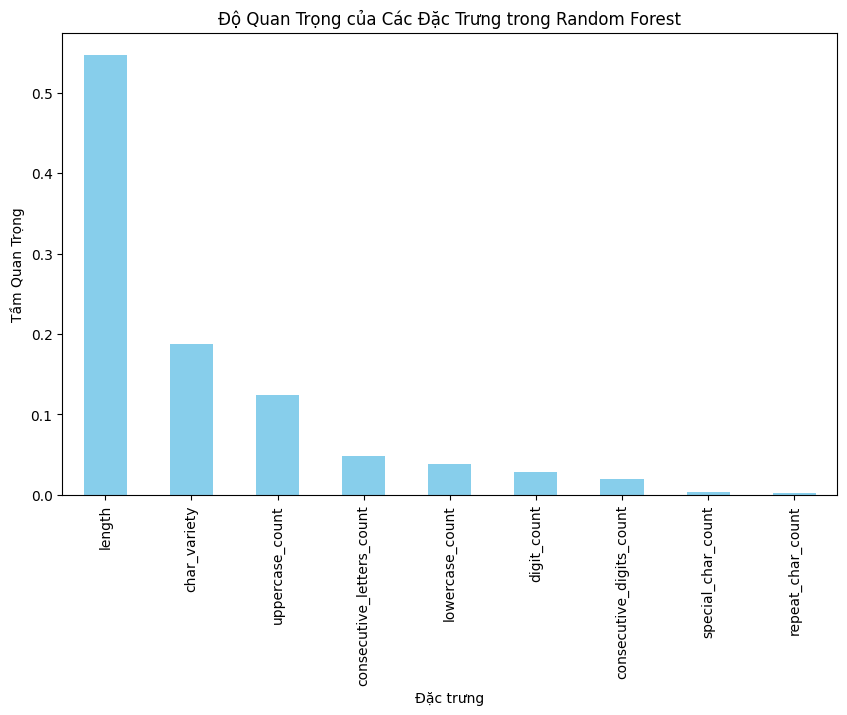

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Đọc dữ liệu đã được tiền xử lý
data = pd.read_csv('processed_password_data.csv')

# Chia dữ liệu thành X (đặc trưng) và y (nhãn)
X = data.drop(columns=['strength'])
y = data['strength']

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Khởi tạo và huấn luyện mô hình Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = rf.predict(X_test)

# Đánh giá hiệu suất
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Phân tích độ quan trọng của các đặc trưng
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)

# Trực quan hóa độ quan trọng của các đặc trưng
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue')
plt.xlabel('Đặc trưng')
plt.ylabel('Tầm Quan Trọng')
plt.title('Độ Quan Trọng của Các Đặc Trưng trong Random Forest')
plt.show()


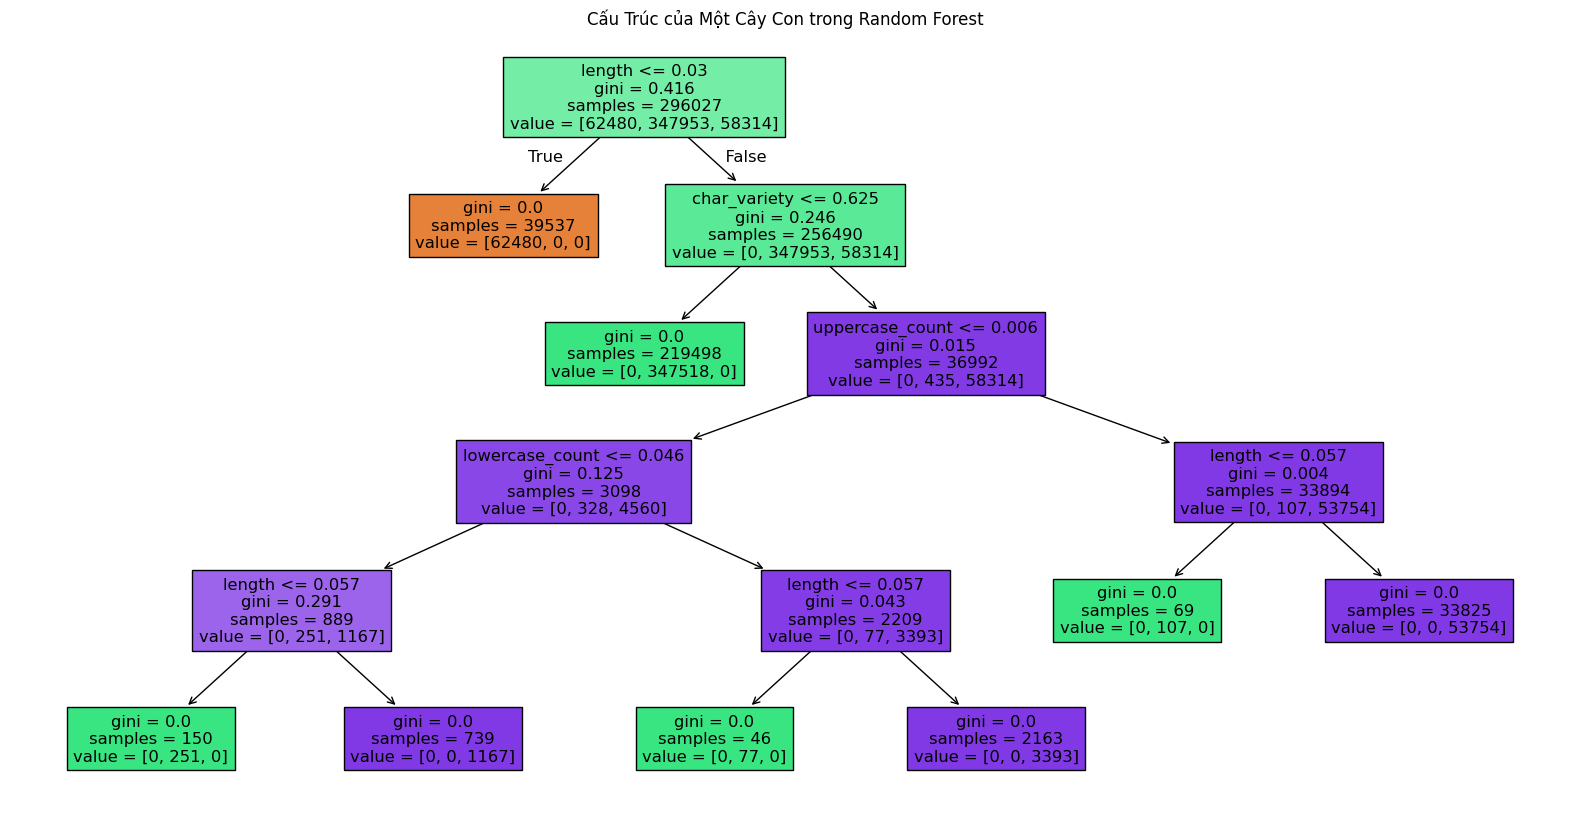

In [13]:
from sklearn.tree import plot_tree

# Hiển thị cấu trúc của một cây con trong Random Forest
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=X.columns, filled=True)
plt.title("Cấu Trúc của Một Cây Con trong Random Forest")
plt.show()


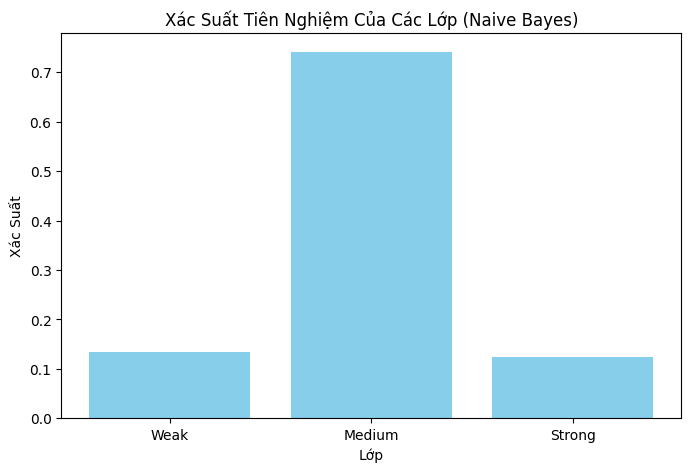

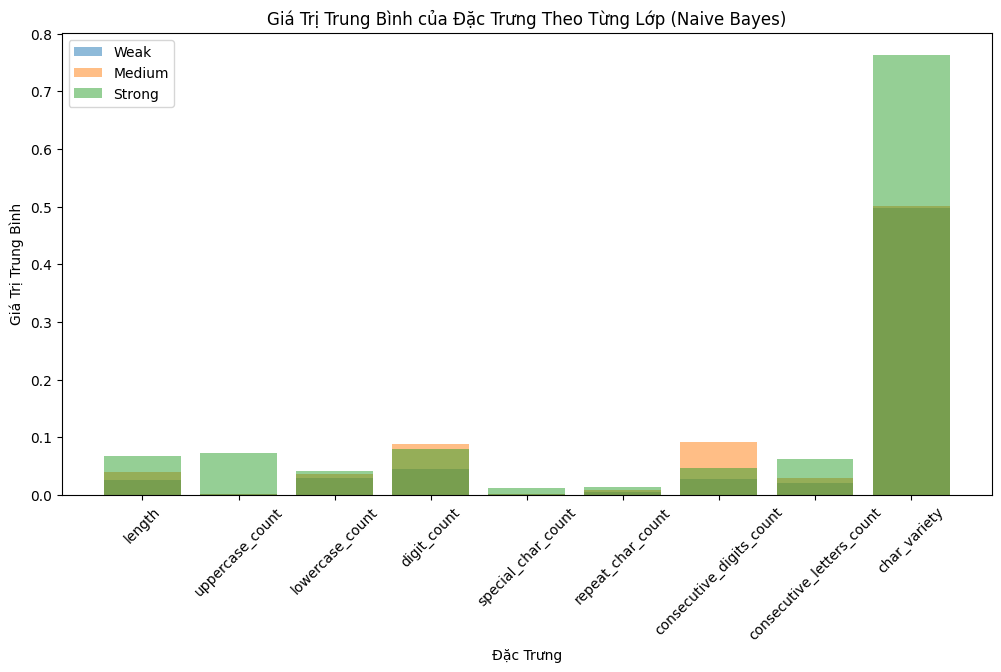

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Huấn luyện mô hình Naive Bayes
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)

# Xác suất tiên nghiệm của các lớp
plt.figure(figsize=(8, 5))
plt.bar(['Weak', 'Medium', 'Strong'], naive_bayes_model.class_prior_, color='skyblue')
plt.title('Xác Suất Tiên Nghiệm Của Các Lớp (Naive Bayes)')
plt.xlabel('Lớp')
plt.ylabel('Xác Suất')
plt.show()

# Lấy log xác suất của từng đặc trưng cho từng lớp
plt.figure(figsize=(12, 6))
for i in range(naive_bayes_model.theta_.shape[0]):
    plt.bar(X.columns, naive_bayes_model.theta_[i], alpha=0.5, label=f'Class {i}')
plt.title('Giá Trị Trung Bình của Đặc Trưng Theo Từng Lớp (Naive Bayes)')
plt.xlabel('Đặc Trưng')
plt.ylabel('Giá Trị Trung Bình')
plt.legend(['Weak', 'Medium', 'Strong'])
plt.xticks(rotation=45)
plt.show()


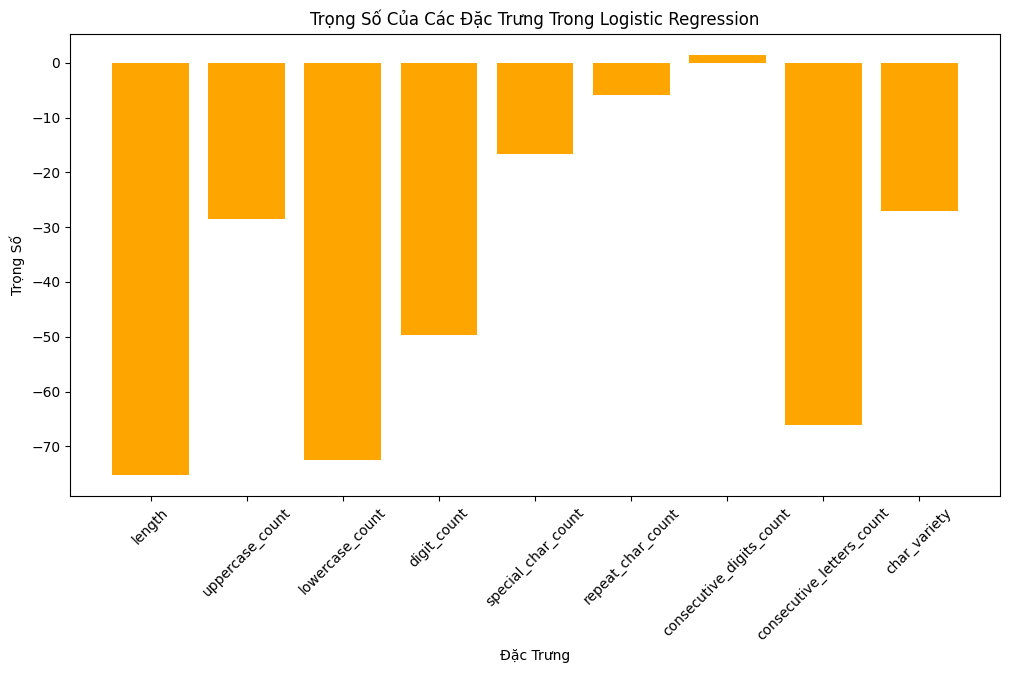

Phần chặn (Intercept): [ 24.27439574   4.67450727 -28.948903  ]


In [17]:
# Huấn luyện mô hình Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Trực quan hóa trọng số của các đặc trưng
plt.figure(figsize=(12, 6))
plt.bar(X.columns, logistic_model.coef_[0], color='orange')
plt.title('Trọng Số Của Các Đặc Trưng Trong Logistic Regression')
plt.xlabel('Đặc Trưng')
plt.ylabel('Trọng Số')
plt.xticks(rotation=45)
plt.show()

# Phần chặn của mô hình
print("Phần chặn (Intercept):", logistic_model.intercept_)
